# Data visualization

The goal, as mentioned in the README, is to practice how we can use dimensionality reduction methods 
to visualize datasets. As such, we won't be going too deep into the methods themselves other than 
a generic explanation on how they work. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pymde    
from umap import UMAP
import umap.plot

df = pd.read_csv("../data/mushrooms.csv")

A:\Software\Coding projects\DimensionVisualization\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A:\Software\Coding projects\DimensionVisualization\.venv\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


# Dataset

The dataset used is called [Mushroom classification](https://www.kaggle.com/datasets/uciml/mushroom-classification). 
The name speaks mostly for itself, containing features about different mushrooms.

My reason for picking this dataset is that it contains no labels about the mushrooms, making it so 
we have to use some techniques to figure out how many categories we are working with. The answer is 
23, but this is not known in the dataset. 

Also, for the fact that it contains enough features, but all of them are simple to interpret.

# Visualization

## Goal

The goal of the dataset is to distinguish between the poisonous and edible mushrooms. Personally, 
I'd like to see if we can plot all 23 mushroom classes on the same plot. I'll see this as two 
separate goals. 

## Data

Here i'll do a surface level inspection of the data.


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

It seems we are working with 23 distinct features for this dataset. Additionally, we appear to have 
8124 rows, none of which are null, saving us cleaning time.

In [3]:
df.head(5)

class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c         n          k  ...                        s   
1            c         b          k  ...                        s   
2            c         b          n  ...                        s   
3            c         n          n  ...                        s   
4            w         b          k  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                      w         p          w   
1                      w                      w         p          w   
2                      w                      w         p          w   
3                      w                      w         p          w   
4                      w                      w         p          w   

  ring-number ring-type spore-print-color population habitat  
0           o         p                 k          s       u  
1           o         p                 n          n       g  
2           o         p                 n          n       m  
3           o         p                 k          s       u  
4           o         e                 n          a       g  

[5 rows x 23 columns]

We know from the problem description that we have a single target column, class, which we'll 
separate later from the features. 

Furthermore it appears we have 22 categorical columns, all of them with a letter code. This means 
we'll need to encode them to numbers if we want to continue. I'm not interested in what these 
letters mean for now, but i do want to know their distribution. 

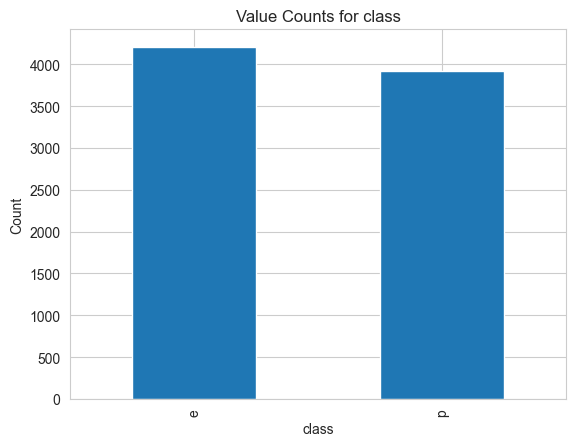

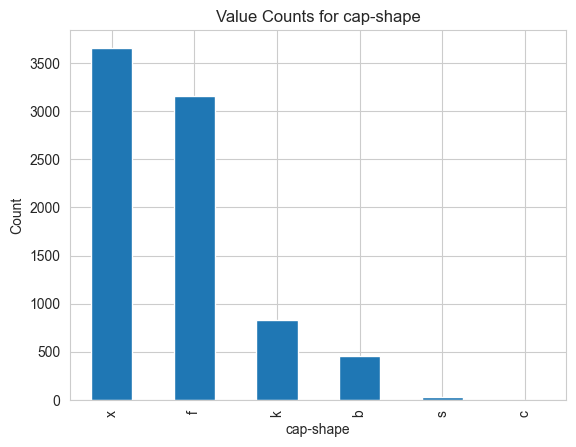

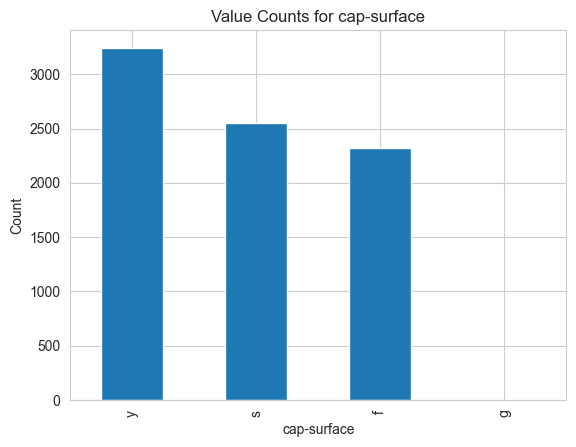

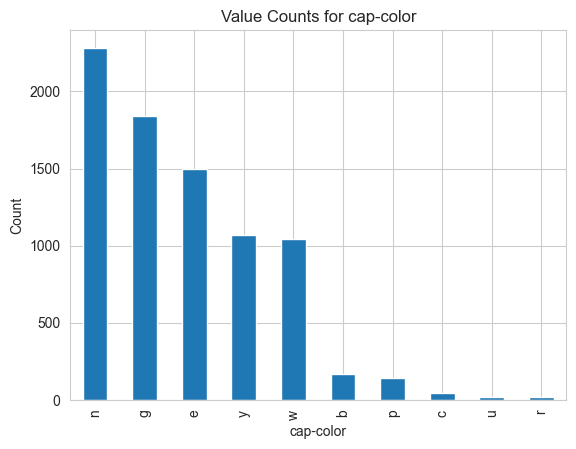

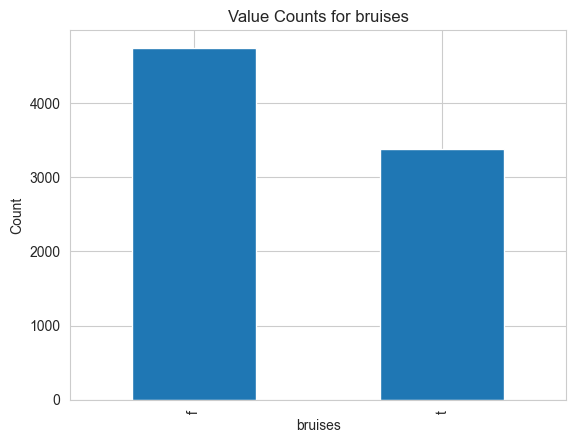

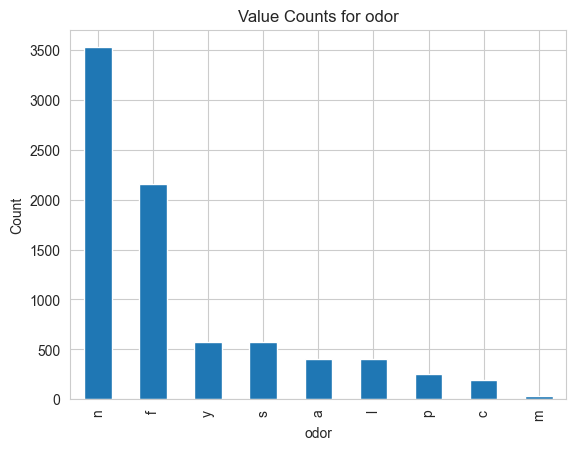

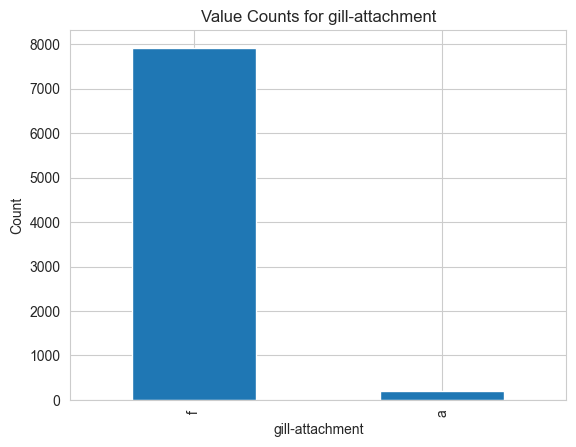

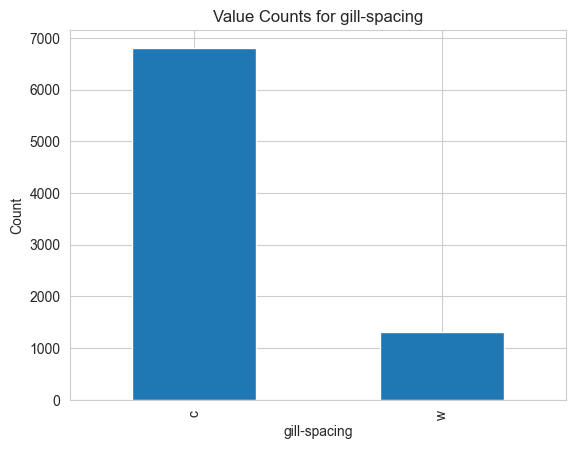

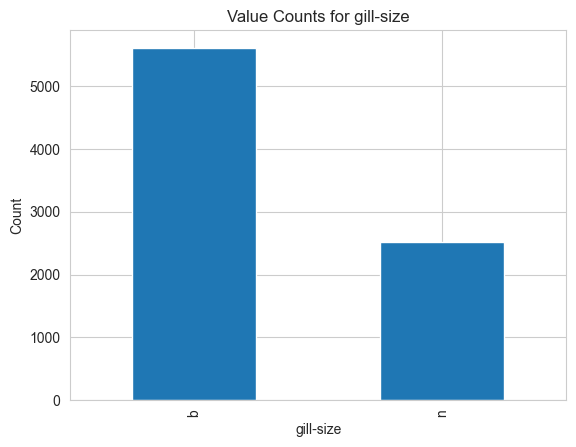

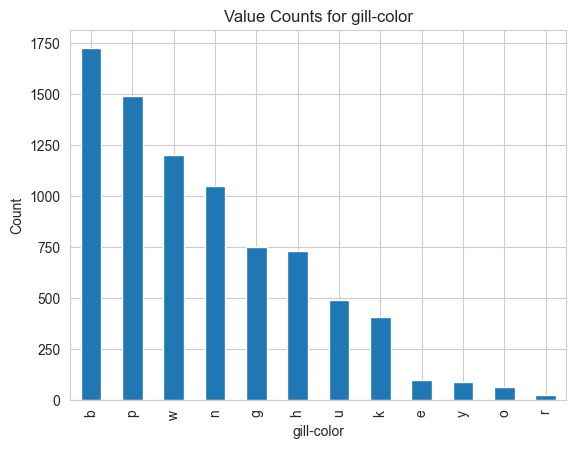

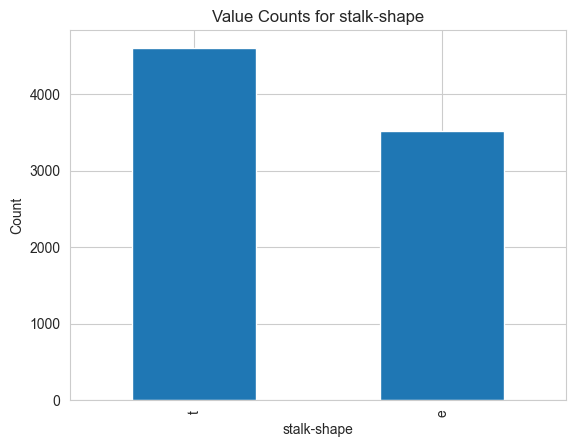

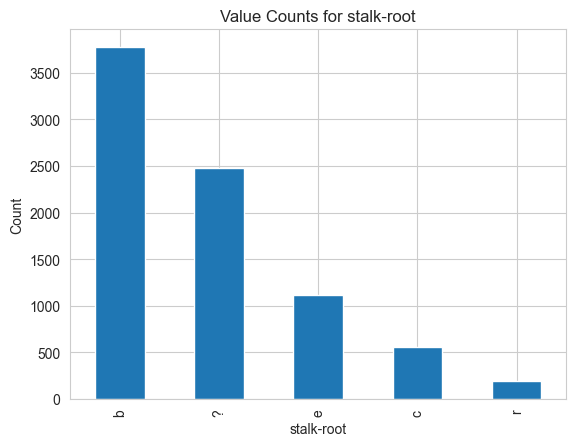

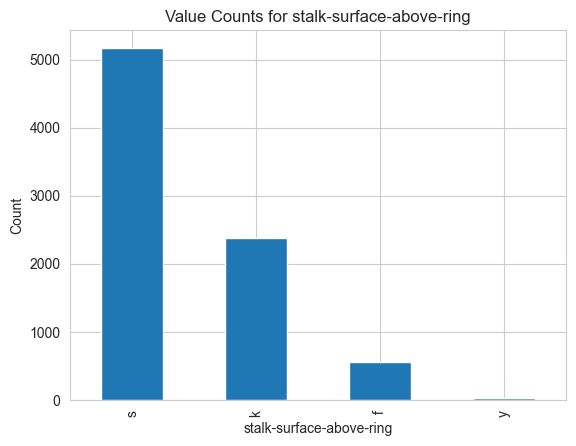

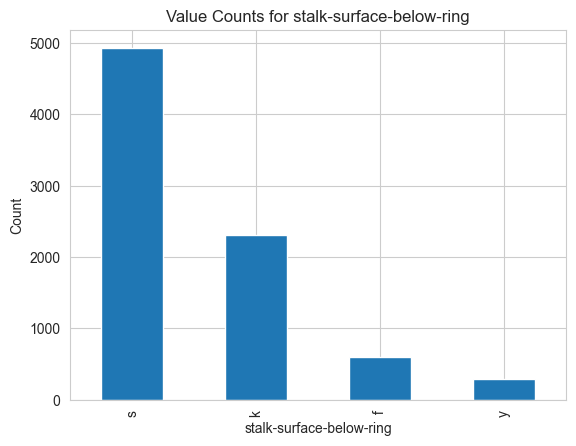

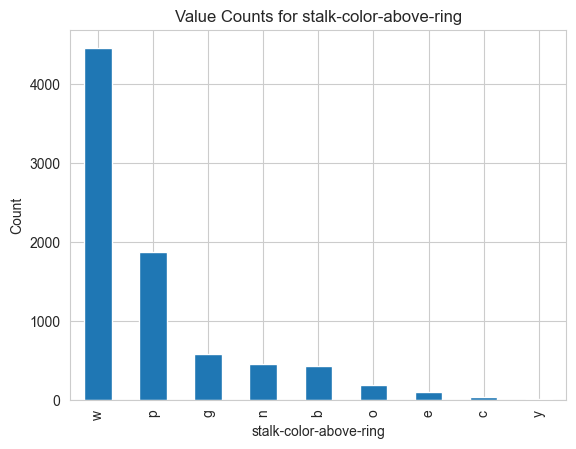

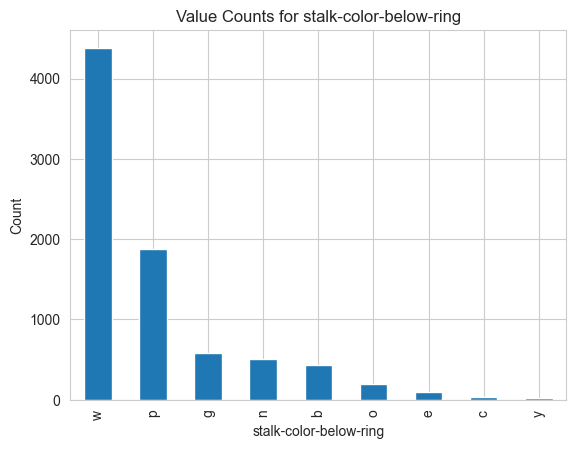

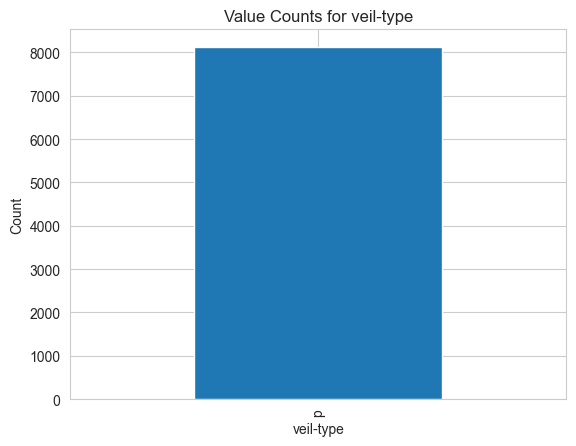

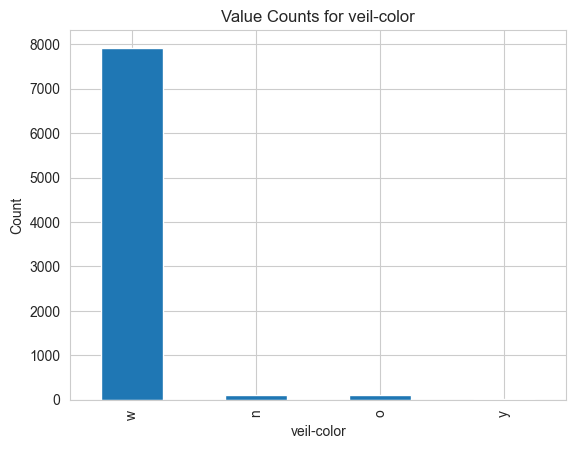

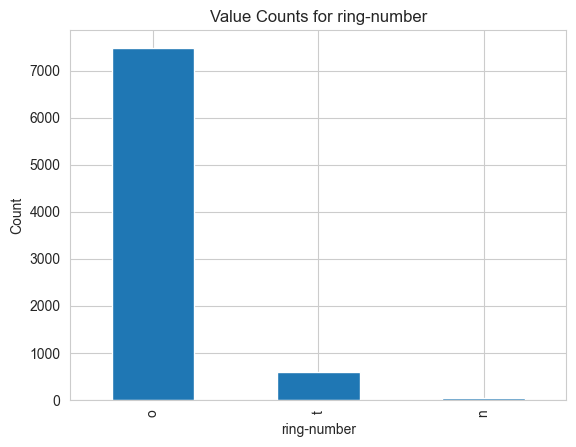

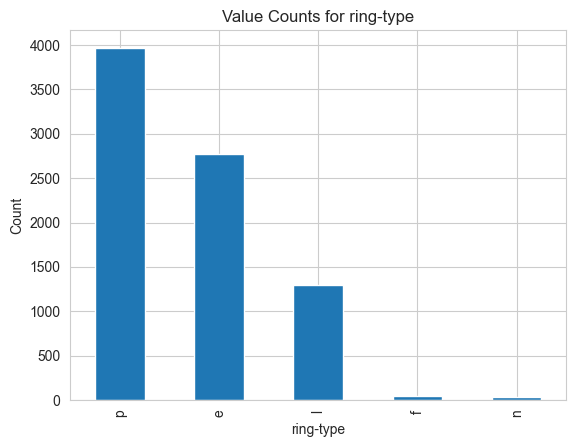

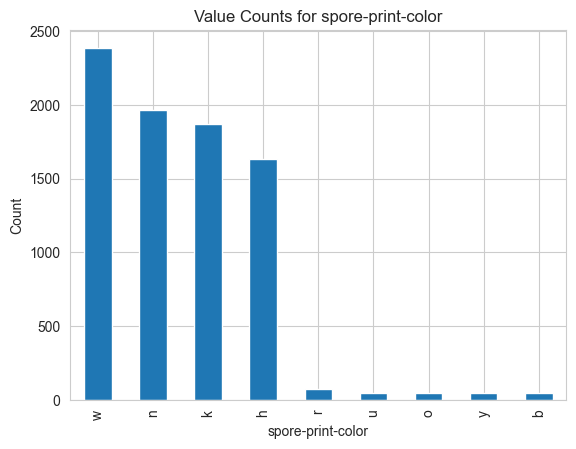

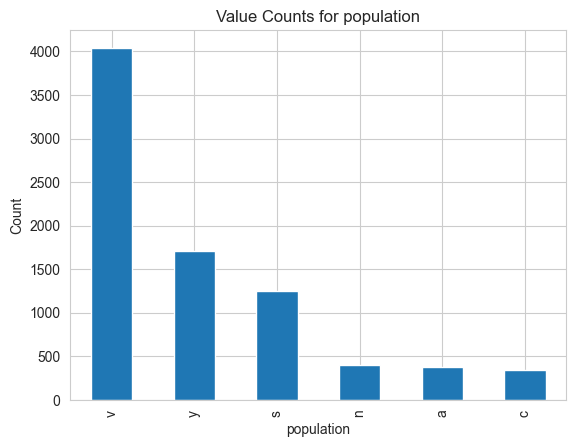

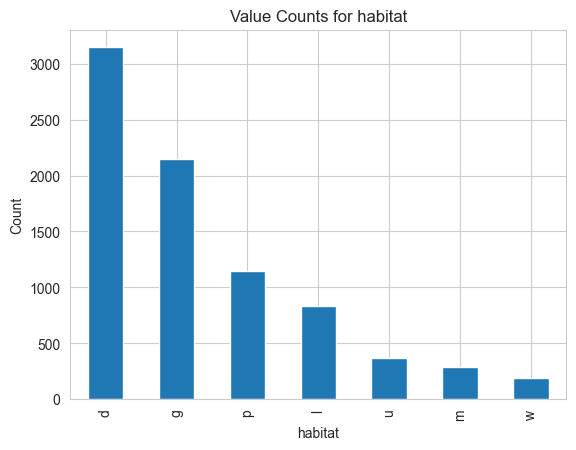

In [4]:
def plot_value_counts(df):
    for col in df.columns:
        value_counts = df[col].value_counts()
        
        # Plot the value counts
        ax = value_counts.plot(kind='bar', title=f'Value Counts for {col}')
        ax.set_ylabel('Count')
        plt.show()

plot_value_counts(df)

With this we can make some basic observations

- The class has a roughly 50/50 spread
- Some columns like gill-attachment and veil-color have a very dominant category, while others 
like habitat have a more distributed spread.
- Veil type only has 1 category, meaning it's not useful.

## Data cleaning

As mentioned, we'll need to encode the columns. We'll do this with a basic Ordinal Encoder, as 
i don't expect the ordering to be an issue.

We'll also drop the veil-type column.

In [5]:
df = df.drop("veil-type", axis=1)

In [6]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()

encoded = encoder.fit_transform(df)
encoded = pd.DataFrame(encoded, columns=df.columns)
encoded

class  cap-shape  cap-surface  cap-color  bruises  odor  \
0       1.0        5.0          2.0        4.0      1.0   6.0   
1       0.0        5.0          2.0        9.0      1.0   0.0   
2       0.0        0.0          2.0        8.0      1.0   3.0   
3       1.0        5.0          3.0        8.0      1.0   6.0   
4       0.0        5.0          2.0        3.0      0.0   5.0   
...     ...        ...          ...        ...      ...   ...   
8119    0.0        3.0          2.0        4.0      0.0   5.0   
8120    0.0        5.0          2.0        4.0      0.0   5.0   
8121    0.0        2.0          2.0        4.0      0.0   5.0   
8122    1.0        3.0          3.0        4.0      0.0   8.0   
8123    0.0        5.0          2.0        4.0      0.0   5.0   

      gill-attachment  gill-spacing  gill-size  gill-color  ...  \
0                 1.0           0.0        1.0         4.0  ...   
1                 1.0           0.0        0.0         4.0  ...   
2                 1.0           0.0        0.0         5.0  ...   
3                 1.0           0.0        1.0         5.0  ...   
4                 1.0           1.0        0.0         4.0  ...   
...               ...           ...        ...         ...  ...   
8119              0.0           0.0        0.0        11.0  ...   
8120              0.0           0.0        0.0        11.0  ...   
8121              0.0           0.0        0.0         5.0  ...   
8122              1.0           0.0        1.0         0.0  ...   
8123              0.0           0.0        0.0        11.0  ...   

      stalk-surface-above-ring  stalk-surface-below-ring  \
0                          2.0                       2.0   
1                          2.0                       2.0   
2                          2.0                       2.0   
3                          2.0                       2.0   
4                          2.0                       2.0   
...                        ...                       ...   
8119                       2.0                       2.0   
8120                       2.0                       2.0   
8121                       2.0                       2.0   
8122                       2.0                       1.0   
8123                       2.0                       2.0   

      stalk-color-above-ring  stalk-color-below-ring  veil-color  ring-number  \
0                        7.0                     7.0         2.0          1.0   
1                        7.0                     7.0         2.0          1.0   
2                        7.0                     7.0         2.0          1.0   
3                        7.0                     7.0         2.0          1.0   
4                        7.0                     7.0         2.0          1.0   
...                      ...                     ...         ...          ...   
8119                     5.0                     5.0         1.0          1.0   
8120                     5.0                     5.0         0.0          1.0   
8121                     5.0                     5.0         1.0          1.0   
8122                     7.0                     7.0         2.0          1.0   
8123                     5.0                     5.0         1.0          1.0   

      ring-type  spore-print-color  population  habitat  
0           4.0                2.0         3.0      5.0  
1           4.0                3.0         2.0      1.0  
2           4.0                3.0         2.0      3.0  
3           4.0                2.0         3.0      5.0  
4           0.0                3.0         0.0      1.0  
...         ...                ...         ...      ...  
8119        4.0                0.0         1.0      2.0  
8120        4.0                0.0         4.0      2.0  
8121        4.0                0.0         1.0      2.0  
8122        0.0                7.0         4.0      2.0  
8123        4.0                4.0         1.0      2.0  

[8124 rows x 22 columns]

In [7]:
y = encoded["class"]
X = encoded.drop("class", axis=1)

## Techniques

### PCA

Principal Component Analysis is a common dimensionality reduction technique. I chose this because 
it's a popular technique, and because if our dataset has linear properties it can be very useful.

In [8]:
# Step 2: Fit PCA
pca = PCA()
pca.fit(X)

# Step 3: Explained Variance
explained_variance = pca.explained_variance_ratio_

# Step 4: Cumulative Explained Variance
cumulative_explained_variance = np.cumsum(explained_variance)

# # Determine the number of components to retain 95% of the variance
n_components = np.argmax(cumulative_explained_variance >= 0.95) + 1

# # Print the number of components
print(f'Number of components to retain 95% variance: {n_components}')

Number of components to retain 95% variance: 10


In [9]:
pca = PCA(n_components=10)
pca_df = pca.fit_transform(X)
pca_df = pd.DataFrame(pca_df, columns=[f"PC{i + 1}" for i in range(10)])
pca_df

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0     0.228207 -0.345472 -1.424425 -1.246722  2.088737  2.645915 -1.032036   
1    -1.936561  4.796912 -3.511668 -1.245720  0.551144 -0.283909  2.550317   
2    -1.654173  2.464362 -3.880827  1.222505  1.043965 -2.052608 -2.190863   
3    -1.252026  1.679664 -3.565488  0.586997  0.679516  2.792790 -0.396476   
4     1.581220 -1.002043 -1.255760 -1.970625  0.070293  3.301132 -1.258234   
...        ...       ...       ...       ...       ...       ...       ...   
8119 -6.469823 -2.308511  0.588111  1.118114  0.617045  1.426498 -1.800509   
8120 -6.525909 -2.280695  1.431399  0.329901  0.274762  1.946724  0.208437   
8121 -1.860507  0.470244  1.190212 -0.306579  0.364383  0.053368 -2.843708   
8122  7.293068 -1.251693 -1.241976  0.781739 -1.592310  0.043870 -0.311706   
8123 -4.835533 -3.583758 -0.112506  2.517632  0.530664  1.923264  1.360926   

           PC8       PC9      PC10  
0     3.643589 -0.925812  0.366808  
1    -0.617764  0.232131  0.075075  
2     0.667470 -0.188417  0.331206  
3     4.161473 -1.013877 -0.498926  
4    -2.004355  0.602214 -1.342796  
...        ...       ...       ...  
8119  0.158004  0.106866 -0.649487  
8120  1.467637 -0.291823 -0.433137  
8121  1.095501 -0.234955 -0.258984  
8122  1.258107 -0.316538 -0.589073  
8123 -0.421498  0.426276 -0.067956  

[8124 rows x 10 columns]

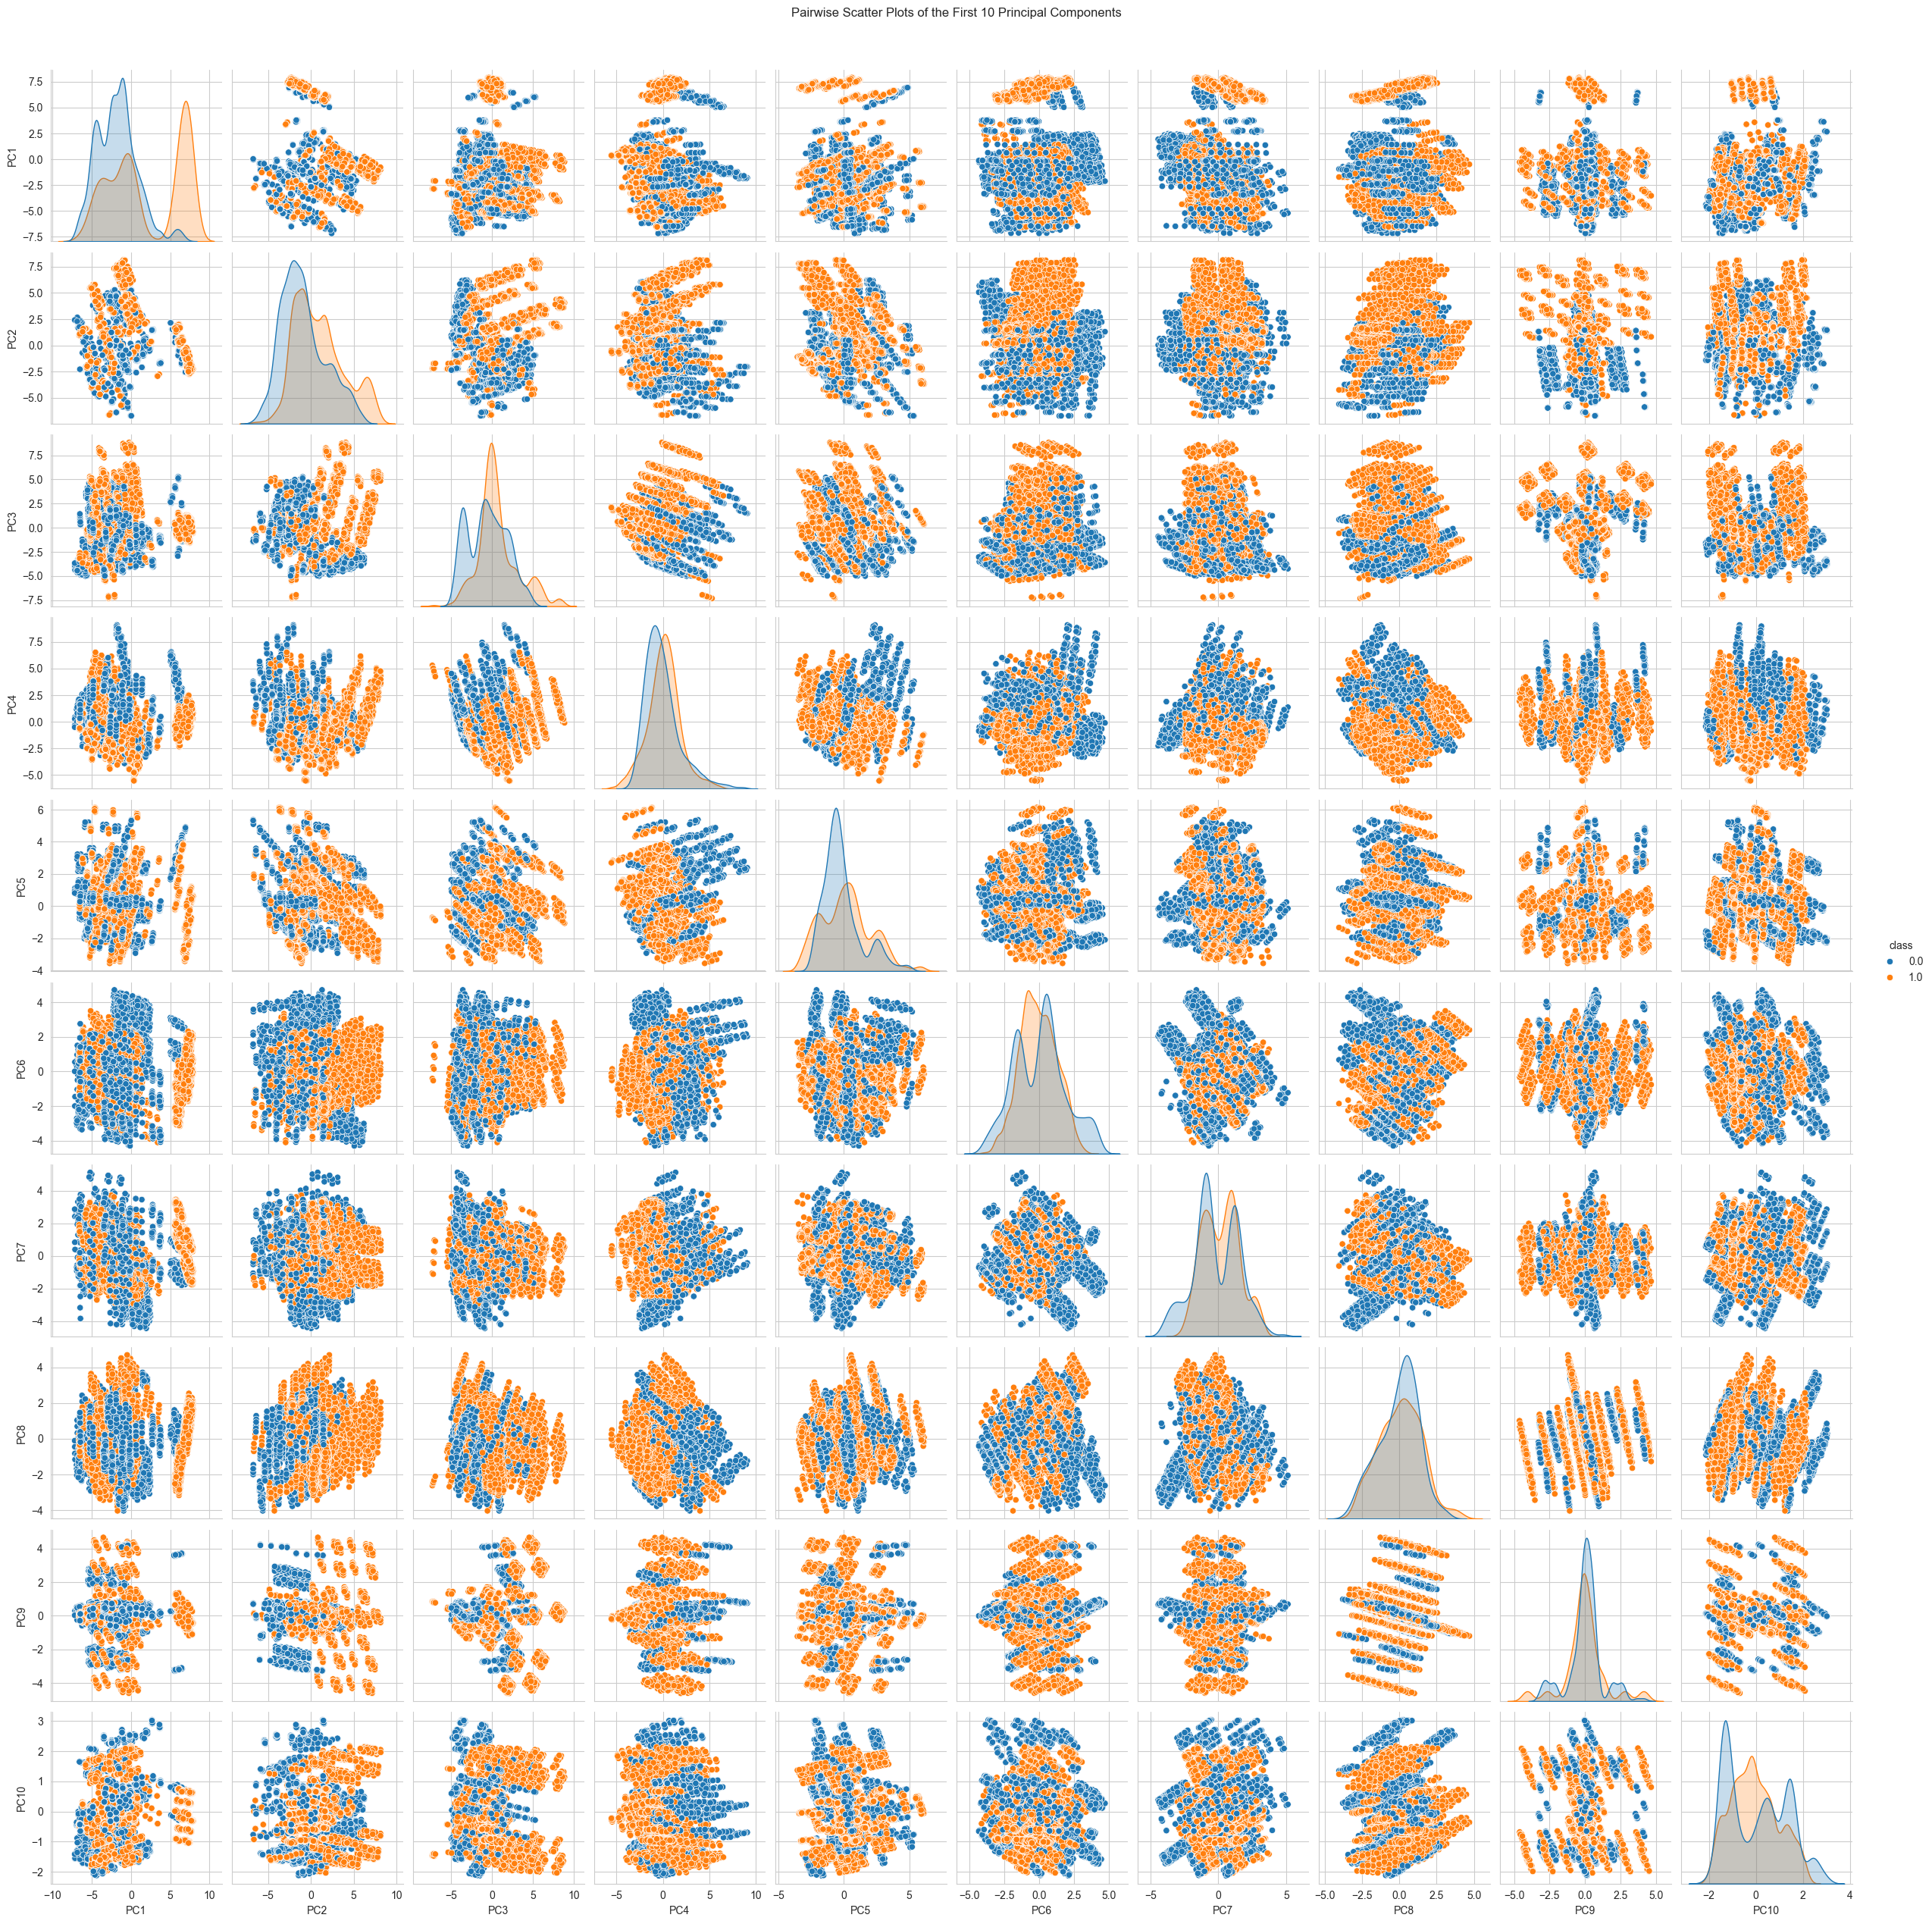

In [10]:
pca_df = pd.concat([pca_df, y], axis=1)
pca_df['class'] = y

sns.pairplot(pca_df, hue="class")
plt.suptitle('Pairwise Scatter Plots of the First 10 Principal Components', y=1.02)
plt.show()

We can see from the explain variance that it would take us around 10 principal components to achieve 95% 
variance. 

We can see in pretty much all of the pairwise plots that there is a lot of overlap between the two 
label categories. This indicates there's no clear component combination that we could use 
to easily separate the two classes.

PC2 combined with PC6 to 8 seems to show some form of clusters despite the overlap, however, among some 
others of to a lesser degree. This tells me that while there is no clear component, there are 
certain features that can have an impact on the classification.


### t-SNE

t-distributed Stochastic Neighbor Embedding is a popular technique for dimensionality reduction. A key 
point is that t-SNE is a non-linear dimensionality reduction technique.

PCA says that >95% of the variance is explained by the first 10 principal components, so we'll use 
that as the basis, and input for TSNE.

In [11]:
tsne_input = pca_df.copy()
tsne_input = tsne_input.drop("class", axis=1)

tsne = TSNE(n_components=2, random_state=42, metric='jaccard', learning_rate='auto', perplexity=30)
tsne_result = tsne.fit_transform(tsne_input)
tsne_result.shape

(8124, 2)

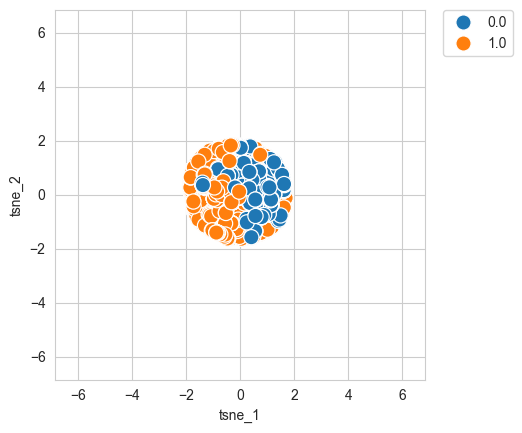

In [12]:
# Plot the result of our TSNE with the label color coded
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

10 components have been chosen due to the PCA results. Random state has been fixed, as t-SNE is a 
stochastic algorithm, and we want the same results when fine tuning the parameters. 

Metric has been set to Jaccard distance, as euclidian distance is not suitable for our dataset, 
this is due to the fact our columns are entirely categorical, instead of a number space.

In the first iteration we see that all the points are clustered into a ball. As described by 
[vd Maaten](https://lvdmaaten.github.io/tsne/, who did some of the t-SNE implementations, it could 
be that we set our perplexity too high, so we'll lower this in the below attempt.

In [13]:
tsne = TSNE(n_components=2, random_state=42, metric='jaccard', learning_rate='auto', perplexity=5)
tsne_result = tsne.fit_transform(tsne_input)
tsne_result.shape

(8124, 2)

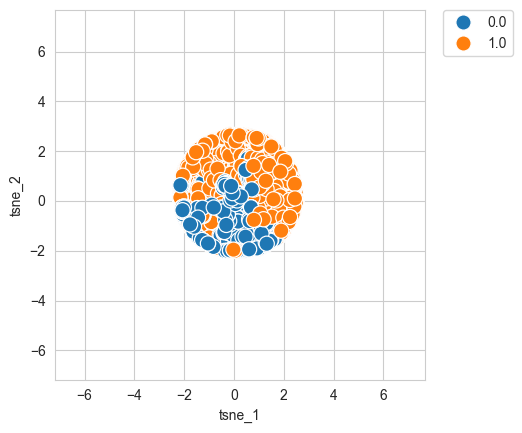

In [14]:
# Plot the result of our TSNE with the label color coded
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

We can see that the perplexity isn't the issue. 

In [15]:
tsne = TSNE(n_components=2, random_state=42, metric='euclidean', learning_rate='auto', perplexity=5)
tsne_result = tsne.fit_transform(tsne_input)
tsne_result.shape

(8124, 2)

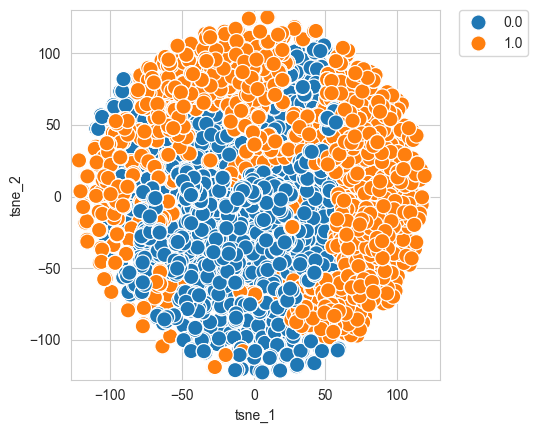

In [16]:
# Plot the result of our TSNE with the label color coded
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:, 0], 'tsne_2': tsne_result[:, 1], 'label': y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax, s=120)
lim = (tsne_result.min() - 5, tsne_result.max() + 5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

Setting the distance back to euclidean also doesn't seem to work. In the sklearn documentation, it is suggested 
we can try lowering the learning rate, but this does the same.

So next, i tried just inputting the original data, instead of the PCA reduce one, to see if that helped.

In [17]:
tsne = TSNE(n_components=2, random_state=42, metric='jaccard', learning_rate=10, perplexity=5)
tsne_result = tsne.fit_transform(X)
tsne_result.shape

A:\Software\Coding projects\DimensionVisualization\.venv\Lib\site-packages\sklearn\metrics\pairwise.py:2317: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


(8124, 2)

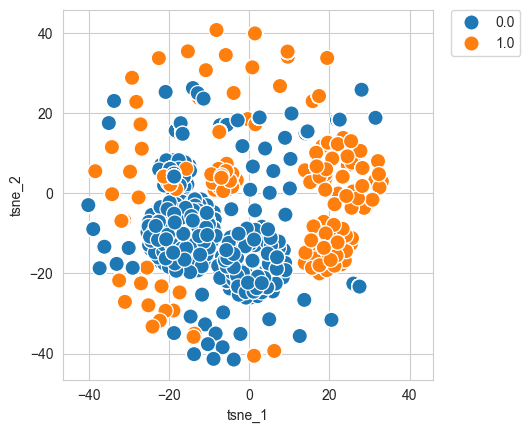

In [18]:
# Plot the result of our TSNE with the label color coded
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:, 0], 'tsne_2': tsne_result[:, 1], 'label': y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax, s=120)
lim = (tsne_result.min() - 5, tsne_result.max() + 5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

This looks much better! We can clearly see multiple clusters of points, and most of the clusters 
are uniform. There are a bunch of outliers, but that's ok here.

Tuning has been tried, but removed as better plots have not been achieved.


### py-MDE

MDE, or Minimum Distortion Embedding, is a technique to create embeddings of data, among which one 
of the use-cases is dimensionality reduction.

How this works is way beyond me, i think because the technique is years old, and only recently 
became more popular.

They provide 2 main functions, preserve neighbours and preserve distance. The former is more 
suitable to preserve local structure, while the latter is better for preserving global structure.

<Axes: >

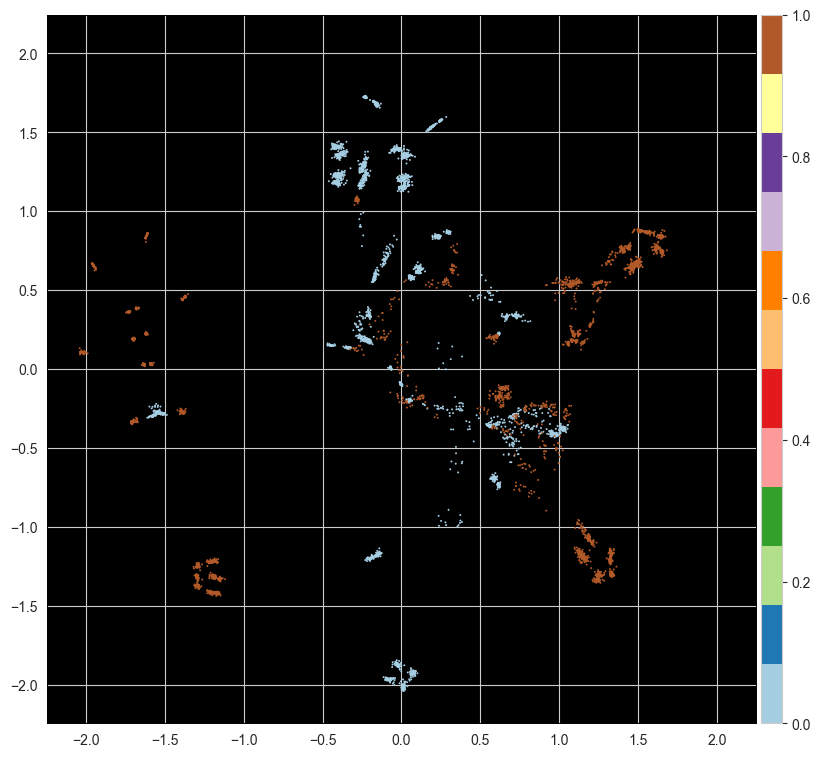

In [53]:
mde_input = encoded.to_numpy()
mde_output = y.to_numpy()
embedding = pymde.preserve_neighbors(mde_input, 
                                     embedding_dim=2,
                                     verbose=False, 
                                     constraint=pymde.Standardized(),
                                     n_neighbors=100).embed()
pymde.plot(embedding, color_by=mde_output, color_map='Paired', background_color='black', marker_size=2)

<Axes: >

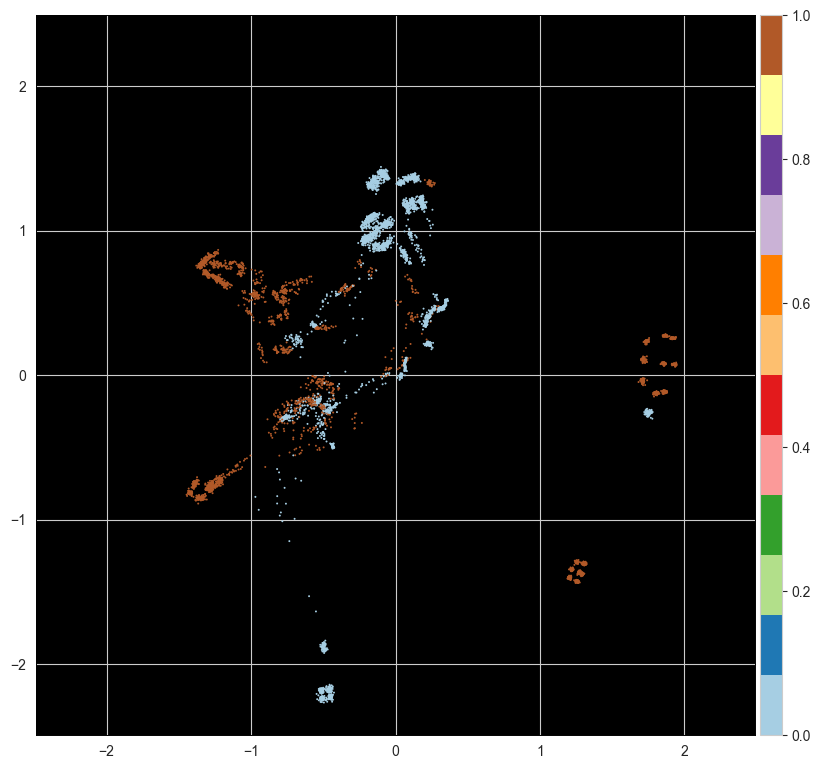

In [54]:
mde_output = y.to_numpy()
embedding = pymde.preserve_neighbors(mde_input, 
                                     embedding_dim=2,
                                     verbose=False, 
                                     constraint=pymde.Standardized(),
                                     n_neighbors=200).embed()
pymde.plot(embedding, color_by=mde_output, color_map='Paired', background_color='black', marker_size=2)

With minimal tuning we can see clear local structures in the data. There are large distinct groups in the middle center, and some smaller groups in the bottom and right of the graph. There's also some overlap in the center. 

### UMAP

A:\Software\Coding projects\DimensionVisualization\.venv\Lib\site-packages\umap\umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


<Axes: >

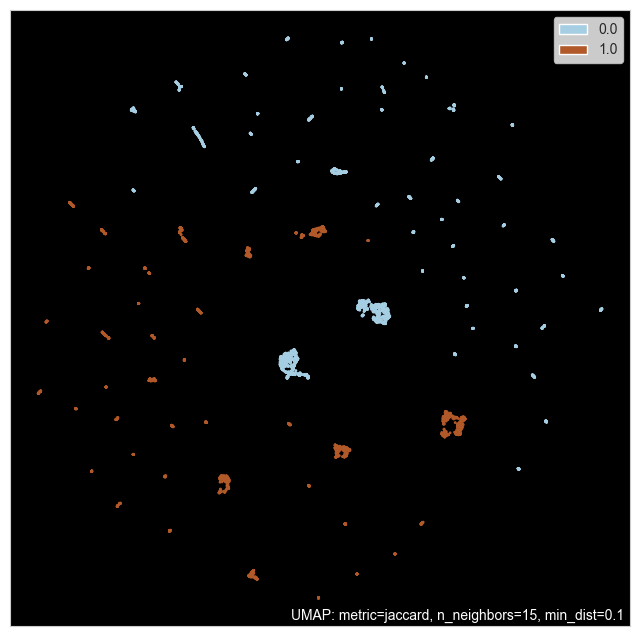

In [20]:
reducer = UMAP(n_components=2, metric='jaccard', n_neighbors=15)
mapper = reducer.fit(encoded)
umap.plot.points(mapper, labels=y, color_key_cmap='Paired', background='black')

We can see that with the first attempt there are some good clusters already. That said, we still have 
many outliers. The n_neighbours controls the balance between local and global structure. I'll try out some larger 
values, since i feel like the result is a bit too spread out right now.

A:\Software\Coding projects\DimensionVisualization\.venv\Lib\site-packages\umap\umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


<Axes: >

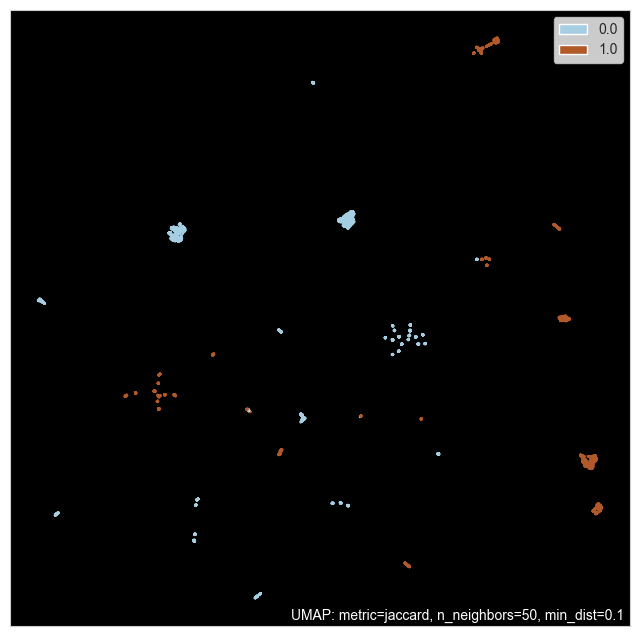

In [21]:
reducer = UMAP(n_components=2, metric='jaccard', n_neighbors=50)
mapper = reducer.fit(encoded)
umap.plot.points(mapper, labels=y, color_key_cmap='Paired', background='black')

A:\Software\Coding projects\DimensionVisualization\.venv\Lib\site-packages\umap\umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


<Axes: >

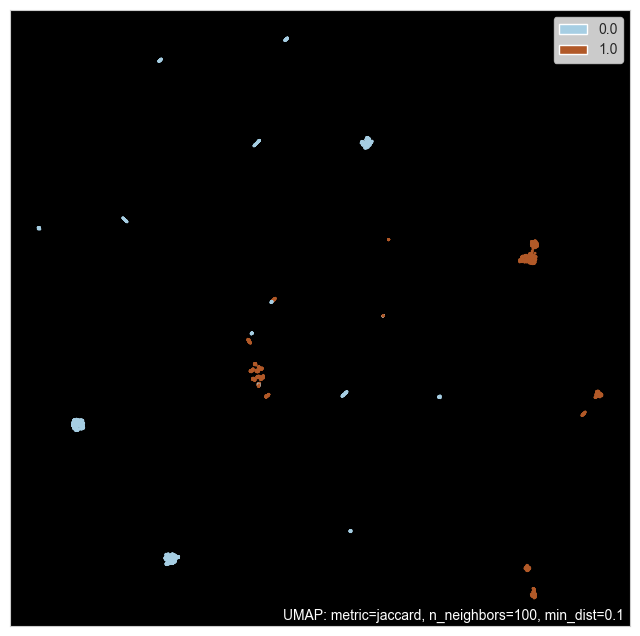

In [22]:
reducer = UMAP(n_components=2, metric='jaccard', n_neighbors=100)
mapper = reducer.fit(encoded)
umap.plot.points(mapper, labels=y, color_key_cmap='Paired', background='black')

A:\Software\Coding projects\DimensionVisualization\.venv\Lib\site-packages\umap\umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


<Axes: >

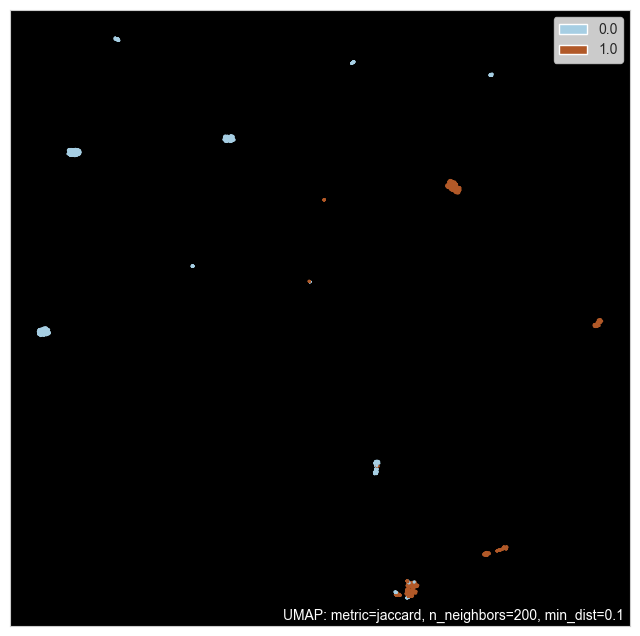

In [23]:
reducer = UMAP(n_components=2, metric='jaccard', n_neighbors=200)
mapper = reducer.fit(encoded)
umap.plot.points(mapper, labels=y, color_key_cmap='Paired', background='black')

We can see that the number of neighbours definitely affects the final results of UMAP. I 
have a preference for the 100 neighbours version, i think it catches the locality the best, while 
only having some minor overlap in classes in the clusters.

The min_dist parameter controls how tightly the points may be packed together. I'd rather have more 
packed than less right now, so i'll see if reducing this does something.


A:\Software\Coding projects\DimensionVisualization\.venv\Lib\site-packages\umap\umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


<Axes: >

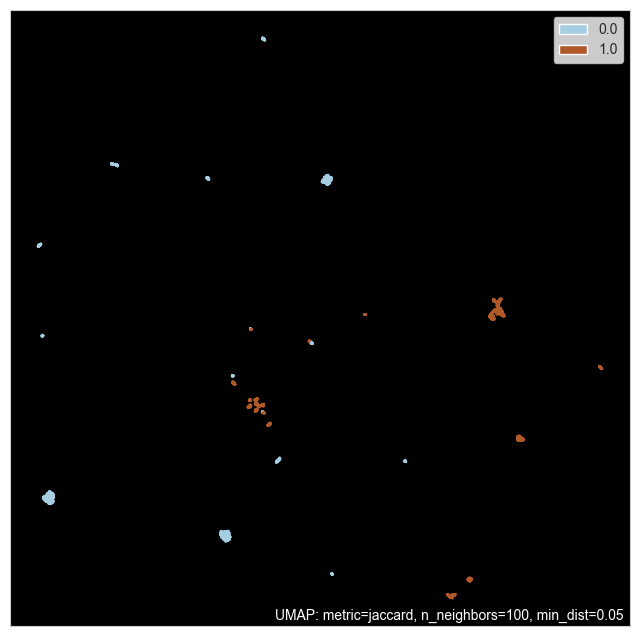

In [24]:
reducer = UMAP(n_components=2, metric='jaccard', n_neighbors=100, min_dist=0.05)
mapper = reducer.fit(encoded)
umap.plot.points(mapper, labels=y, color_key_cmap='Paired', background='black')

A:\Software\Coding projects\DimensionVisualization\.venv\Lib\site-packages\umap\umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


Text(0.5, 0.92, 'test')

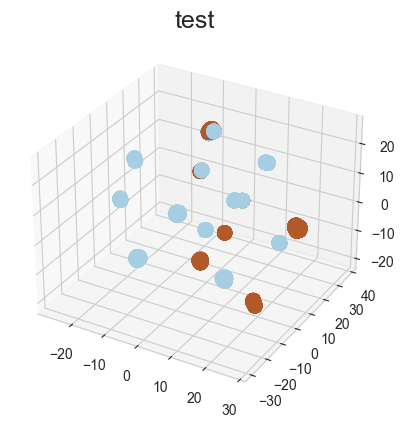

In [25]:
reducer = UMAP(n_components=3, metric='jaccard', n_neighbors=100, min_dist=0.05)
u = reducer.fit_transform(encoded)

f = plt.figure()
ax = f.add_subplot(111, projection='3d')
ax.scatter(u[:,0], u[:,1], u[:,2], c=y, s=100, cmap='Paired')
plt.title("test", fontsize=18)

This result is interesting, as we can see that there are now uniform groups of datapoints. There are multiple single points though

# Conclusion

With the above experiments i've seen that manifold learning is a suitable technique to visualize your data, assuming that the data's dimensionality is high enough. 

All of the 4 techniques are suitable in their own way, and which to use really depends on the characteristics of your data. Because of that, i wouldn't use 
manifold learning as the very first step, minimally precede it by some data statistics at least.

As far as whether i can answer my goals, partly:
- For the most part, it seems that each category is well separated, and poisonous and edible mushrooms have distinct traits. However, we can also see there's definitely some overlap for a subset of the mushrooms, meaning 
these may be hard to cluster together. I couldn't see that in the last UMAP result though, so maybe they can be separated perfectly after all?
- For whether i can separate it into all 23 groups, the answer is a defining no. Manifold learning doesn't seem suitable for that task here.